# Random Forest Classifier

In [1]:
import os
import pickle
import random
import re
import scipy
import torch
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from label_processor import LabelProcessorSimplified

from models.random_forest_early_stopping import RandomForestEarlyStopping, StratifiedKFold3

from sklearn import metrics
from sklearn.base import clone
from sklearn.compose import make_column_transformer
from sklearn.decomposition import  PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

from tqdm.auto import tqdm, trange

In [2]:
save_directory = "saved/"

In [3]:
def intersection_df(df1, df2, col1=None, col2=None):
    col1 = df1.index if col1 is None else df1[col1]
    col2 = df2.index if col2 is None else df2[col2]
    assert col1.name == col2.name
    ids = set(col1)
    ids.intersection_update(col2)
    df1 = df1[col1.isin(ids)]
    df2 = df2[col2.isin(ids)]
    return df1, df2

def predict_decision_threshold(classifier, X_train, X_test, y_train, y_test):
    y_pred_prob_train = classifier.predict_proba(X_train)[:,1]
    decision_threshold = np.quantile(y_pred_prob_train, 1 - y_train.mean())
    y_pred_prob = classifier.predict_proba(X_test)[:,1]
    y_pred = y_pred_prob > decision_threshold
    return y_pred, y_pred_prob


def evaluate(classifier, X_train, X_test, y_train, y_test):
    y_pred, y_pred_prob = predict_decision_threshold(classifier, X_train, X_test, y_train, y_test)
    print(metrics.confusion_matrix(y_test, y_pred))
    
    m = {
        "precision": metrics.precision_score(y_test, y_pred),
        "recall" : metrics.recall_score(y_test, y_pred),
        "f1" : metrics.f1_score(y_test, y_pred),
        "roc_auc" : metrics.roc_auc_score(y_test, y_pred_prob),
        "average_precision": metrics.average_precision_score(y_test, y_pred_prob),
        "matthews": metrics.matthews_corrcoef(y_test,y_pred),
        "spearman":scipy.stats.spearmanr(y_pred_prob, y_test)[0]
    }
    return m

def prepend_keys(d, prepend):
    return {prepend + k:v for k,v in d.items()}

def dropna_both(ds, l):
    indxs = l.dropna().index
    return ds[indxs],  l[indxs]

# Prepro

In [4]:
def get_ds(k):
    y = l_df[k].dropna()
    convo_ids = set(y.index)
    indxs = [i for i,j in enumerate(conversations_tfidf.index) if j in convo_ids];
    x = dataset_tfidf[indxs]
    return x,y

## Get Basic Features

In [ ]:
df2 = pickle.load(open(save_directory+"/selected_messages.pickle","rb"))
messages = df2.copy()
messages = messages[['conversation_id','message','timestamp','interaction']]

In [20]:
## gets conversations by conversation_id
b = messages.conversation_id.unique()
conversations = pd.DataFrame(b,columns=["conversation_id"])
conversations = conversations.set_index("conversation_id").sort_index()
del b

In [44]:
## gets total time of conversations by conversation_id
messages['timestamp'] = pd.to_datetime(messages.timestamp)
b = messages.groupby('conversation_id').timestamp
conversations['total_time_seconds'] = ((b.max()-b.min()) / np.timedelta64(1, 's')).astype('int')
del b

In [22]:
## gets the length of each message in characters and words

tqdm.pandas(desc="message_char_len")
messages["message_char_len"] = messages.message.progress_apply(lambda x: len(x) if type(x) == str else 0)
# messages["message_word_len"] = messages.message.apply(nltk.tokenize.word_tokenize).apply(lambda x: len(x))

tqdm.pandas(desc="message_word_len")
word_regex = re.compile("(?u)\\b\\w{2,}\\b")
messages["message_word_len"] = messages.message.progress_apply(lambda x:len(word_regex.findall(x)) if type(x) == str else 0)
# They're mostly the same, only because there's no punctuation

message_char_len:   0%|          | 0/18390946 [00:00<?, ?it/s]

message_word_len:   0%|          | 0/18390946 [00:00<?, ?it/s]

In [23]:
## gets texter messages and counselor messages separately

texter_messages = messages[messages.interaction == "texter"]
counselor_messages = messages[messages.interaction.isin(["counselor","observer"])]

In [24]:
## gets the length of texter's side of the conversation in characters and words
ser = texter_messages.groupby("conversation_id").message_char_len.sum()
ser.name = "texter_message_char_len"
conversations = conversations.join(ser, on="conversation_id")
 
ser = texter_messages.groupby("conversation_id").message_word_len.sum()
ser.name = "texter_message_word_len"
conversations = conversations.join(ser, on="conversation_id")

## gets the length of counselor's side of the conversation in characters and words

ser = counselor_messages.groupby("conversation_id").message_char_len.sum()
ser.name = "counselor_message_char_len"
conversations = conversations.join(ser, on="conversation_id")
 
ser = counselor_messages.groupby("conversation_id").message_word_len.sum()
ser.name = "counselor_message_word_len"
conversations = conversations.join(ser, on="conversation_id")
 
## drops the NA messsages, groups by conversation id
## gets the number of messages from both texters and counselors each 
ser = messages[~messages.message.isna()].groupby("conversation_id").interaction.value_counts().unstack(1).fillna(0)
ser.columns = ["num_messages_" + i for i in ser.columns]
conversations = conversations.join(ser, on="conversation_id")

In [25]:
[print(i) for i in conversations.columns];

total_time
texter_message_char_len
texter_message_word_len
counselor_message_char_len
counselor_message_word_len
num_messages_bot
num_messages_counselor
num_messages_texter


In [26]:
## replaces all NA values with 0
conversations.texter_message_char_len.fillna(0, inplace=True)
conversations.texter_message_word_len.fillna(0, inplace=True)
conversations.counselor_message_char_len.fillna(0, inplace=True)
conversations.counselor_message_word_len.fillna(0, inplace=True)

## gets the average word length and number of words per message for counselors and texters
conversations["texter_avg_word_len"] = conversations.texter_message_char_len / conversations.texter_message_word_len
conversations["counselor_avg_word_len"] = conversations.counselor_message_char_len / conversations.counselor_message_word_len

conversations["texter_avg_words_per_message"] = conversations.texter_message_word_len / conversations.num_messages_texter
conversations["counselor_avg_words_per_message"] = conversations.counselor_message_word_len / conversations.num_messages_counselor

## average time per message
conversations["avg_time_per_message_seconds"] = conversations.total_time / (conversations.num_messages_counselor + conversations.num_messages_texter)

## replaces all NA values with 0 again
conversations.texter_avg_word_len.fillna(0, inplace=True)
conversations.counselor_avg_word_len.fillna(0, inplace=True)
conversations.texter_avg_words_per_message.fillna(0, inplace=True)
conversations.counselor_avg_words_per_message.fillna(0, inplace=True)

In [27]:
conversations.columns

Index(['total_time', 'texter_message_char_len', 'texter_message_word_len',
       'counselor_message_char_len', 'counselor_message_word_len',
       'num_messages_bot', 'num_messages_counselor', 'num_messages_texter',
       'texter_avg_word_len', 'counselor_avg_word_len',
       'texter_avg_words_per_message', 'counselor_avg_words_per_message',
       'avg_time_per_message'],
      dtype='object')

In [28]:
## drops all conversations with texter/counselor message length of 0 
## drops conversations with 0 bot messages also 
conversations = conversations[~((conversations['texter_message_char_len']==0) | 
                                (conversations['counselor_message_char_len']==0) | 
                                (conversations['num_messages_bot']==0))]

In [52]:
## saves basic features
conversations.to_pickle(save_directory+"/basic_features.pickle")

# Basic

In [4]:
basic_features = pd.read_pickle("saved/basic_features.pickle")

In [5]:
train_ids = torch.load(save_directory+"/train_convos.torch")
test_ids = torch.load(save_directory+"/test_convos.torch")

In [6]:
train_ids = list(train_ids.intersection(basic_features.index))
test_ids = list(test_ids.intersection(basic_features.index))

In [7]:
labelizer = torch.load(save_directory+"/labelizer.torch")
l_df = labelizer.df

In [8]:
ds_train, l_train = basic_features.loc[train_ids].values, l_df.loc[train_ids]
ds_test, l_test = basic_features.loc[test_ids].values, l_df.loc[test_ids]

l_train.index = range(len(train_ids))
l_test.index = range(len(test_ids))

wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/data-imperial/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=81686     1.0
2889      1.0
65637     1.0
231241    1.0
147130    0.0
         ... 
72513     1.0
393       1.0
241146    1.0
32370     1.0
225786    1.0
Name: 64_Yes, Length: 47311, dtype: float64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "



[[ 194  485]
 [ 514 4064]]
[[ 111  242]
 [ 236 2121]]
64_Yes
[[ 111  242]
 [ 236 2121]]
precision            0.897588
recall               0.899873
f1                   0.898729
roc_auc              0.701643
average_precision    0.933153
matthews             0.215891
spearman             0.235111
dtype: float64


score,0.92556
n_estimators,30
_runtime,7
_timestamp,1630494027
_step,6
val precision,0.89338
val recall,0.88772
val f1,0.89054
val roc_auc,0.6778
val average_precision,0.92556
val matthews,0.17039


score,▁████▇
n_estimators,▁▂▄▅▇█
_runtime,▁▁▁▁▁▁█
_timestamp,▁▁▁▁▁▁█
_step,▁▂▃▅▆▇█
val precision,▁
val recall,▁
val f1,▁
val roc_auc,▁
val average_precision,▁
val matthews,▁


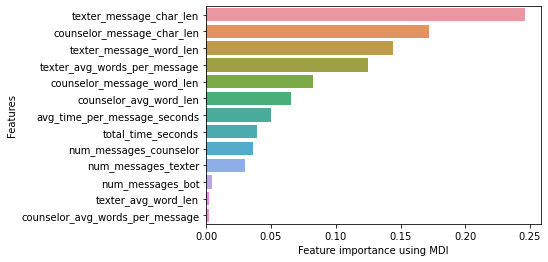

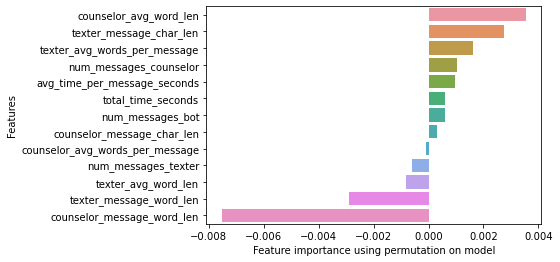

In [36]:
config={"min_estimators":5,
"max_estimators":5000,
"max_depth":4,
"class_weight":"balanced",
"step_size":5,
"patience":3}

for label in tqdm([
#     "19_desire_x",
#     "19_intent_x",
#     "19_capability_x",
#     "19_timeframe_x",
#     "69>13 or younger",
#     "69>14-24",
#     "69>24 or younger",
#     "18_substance", 
#     "18_depressed", 
#     "18_self_harm",
#     "18_suicide",
#     "18_substance", 
    "64_Yes",
#     "65>1 (slightly helpful)",
#     "65>2",
#     "65>3",
#     "65>4",
#     "241_I see a therapist or doctor in person",
#     "74_Heterosexual or Straight",
#     "75_White",
#     "69>24 or younger",
#     "73_Male",
#     "33_good"
]):

    wandb.init(project="basic_baseline",reinit=True,
               config={
                   **config,
                "label":label
               }, tags=['basic_features'])
    
    min_estimators = wandb.config.min_estimators
    max_estimators = wandb.config.max_estimators
    max_depth = wandb.config.max_depth
    class_weight = wandb.config.class_weight
    step_size = wandb.config.step_size
    patience = wandb.config.patience

    X, y = dropna_both(ds_train, l_train[label].astype('float'))
    X_test, y_test = dropna_both(ds_test, l_test[label].astype('float'))

#     print(X.shape, y.shape)
#     print(X_test.shape, y_test.shape)

    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.1)

    u = np.unique(y_train)
    class_weight = {i:j for i,j in zip(u,compute_class_weight('balanced',u, y_train))}

    classifier = RandomForestEarlyStopping(
        min_estimators = min_estimators,
        max_estimators = max_estimators,
        scoring = metrics.average_precision_score,
        step_size=step_size,
        patience=patience,
        max_depth = max_depth,
        class_weight = class_weight,
        n_jobs=2)

    classifier.fit_with_cv(X_train,y_train, X_val, y_val,log_wandb=True)


    wandb.log({
        **prepend_keys(evaluate(classifier, X_train, X_val, y_train, y_val), "val "),
        **prepend_keys(evaluate(classifier, X_train, X_test, y_train, y_test), "test ")
    })
    print(label)
    print(pd.Series(evaluate(classifier, X_train, X_test, y_train, y_test)))
    wandb.join()
    
    ## getting the feature importances
    feature_imp = pd.Series(classifier.feature_importances_, 
                            index=basic_features.columns).sort_values(ascending=False)
#     display(feature_imp)

    ##Creating a barplot
    sns.barplot(x=feature_imp, y=feature_imp.index)
    ##Add labels to graph
    plt.xlabel('Feature importance using MDI')
    plt.ylabel('Features')
    plt.show()
    
    ## getting the permutation importances
    perm_imp = pd.Series(permutation_importance(classifier, X_test, y_test, n_jobs=-1).importances_mean, 
                        index=basic_features.columns).sort_values(ascending=False)
    
    ## creating a barplot
    sns.barplot(x=perm_imp, y=perm_imp.index)
    ##Add labels to graph
    plt.xlabel('Feature importance using permutation on model')
    plt.ylabel('Features')
    plt.show()
    


In [37]:
columns = ["total time (seconds)", "conversation length in characters (texter)", "conversation length in words (texter)", 
           "conversation length in characters (volunteer)", "conversation length in words (volunteer)", "number of bot messages", 
           "number of volunteer messages", "number of texter messages", "average word length (texter)", 
           "average word length (volunteer)", "average words per message (texter)", "average words per message (volunteer)", 
           "average time per message (seconds)"]

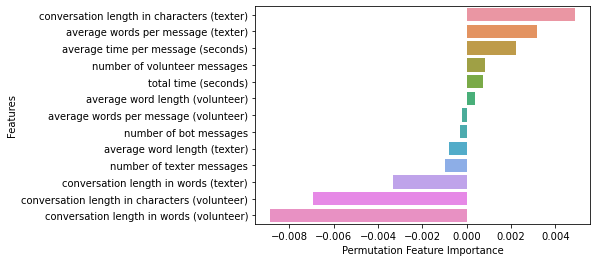

In [39]:
## getting the permutation importances
perm_imp = pd.Series(permutation_importance(classifier, X_test, y_test, n_jobs=-1).importances_mean, 
                    index=columns).sort_values(ascending=False)

## creating a barplot
sns.barplot(x=perm_imp, y=perm_imp.index)
##Add labels to graph
plt.xlabel('Permutation Feature Importance')
plt.ylabel('Features')
plt.savefig("figs/basic_features_helpful_feature_imp.pdf", bbox_inches='tight')
plt.show()

In [25]:
for i in basic_features.columns:
    print(f"{i}: {basic_features[i].mean()}, {basic_features[i].median()}")

total_time_seconds: 3927.6493173849935, 3378.0
texter_message_char_len: 1510.827554676677, 1274.0
texter_message_word_len: 272.57549251010084, 230.0
counselor_message_char_len: 2334.9774490551904, 2168.0
counselor_message_word_len: 421.10793496911225, 391.0
num_messages_bot: 7.101410398001592, 7.0
num_messages_counselor: 21.179011206618764, 20.0
num_messages_texter: 22.36561559287117, 20.0
texter_avg_word_len: 5.539017008931529, 5.538251366120218
counselor_avg_word_len: 5.53635248178143, 5.536
texter_avg_words_per_message: 13.38120268401026, 11.644444444444444
counselor_avg_words_per_message: 20.154795408967708, 20.22222222222222
avg_time_per_message_seconds: 103.70706835756428, 84.62295081967213
